In [38]:
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
df = pd.read_csv("/content/drive/MyDrive/IIIT sonepat /placedata v2.0 synthetic.csv")

In [41]:
df.drop(columns='StudentID', inplace=True)

In [42]:
numerical_cols = [feature for feature in df.columns if df[feature].dtype != 'O']

In [43]:
df.replace({"NotPlaced":0.0, "Placed" :1.0}, inplace = True)
categorical_cols = [feature for feature in df.columns if df[feature].dtype == 'O']
df.replace({"Yes":0, "No" :1}, inplace = True)
print(categorical_cols)
print(numerical_cols)

['ExtracurricularActivities', 'PlacementTraining']
['CGPA', 'Internships', 'Projects', 'Workshops/Certifications', 'AptitudeTestScore', 'SoftSkillsRating', 'SSC_Marks', 'HSC_Marks']


In [44]:
df.head(5)

,CGPA,Internships,Projects,Workshops/Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
0,7.5,1,1,1,65,4.4,1,1,61,79,0.0
1,8.9,0,3,2,90,4.0,0,0,78,82,1.0
2,7.3,1,2,2,82,4.8,0,1,79,80,0.0
3,7.5,1,1,2,85,4.4,0,0,81,80,1.0
4,8.3,1,2,2,86,4.5,0,0,74,88,1.0


In [45]:
inputs = {i:keras.layers.Input(shape = (1,), name = i) for i in numerical_cols+categorical_cols}
print(inputs)

{'CGPA': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'CGPA')>, 'Internships': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Internships')>, 'Projects': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Projects')>, 'Workshops/Certifications': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Workshops/Certifications')>, 'AptitudeTestScore': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'AptitudeTestScore')>, 'SoftSkillsRating': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'SoftSkillsRating')>, 'SSC_Marks': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'SSC_Marks')>, 'HSC_Marks': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'HSC_Marks')>, 'ExtracurricularActivities': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ExtracurricularActivities')>, 'PlacementTraining': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'PlacementTraining')>}

In [46]:
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42)
print(train_df.head(5))
print(test_df.head(5))

      CGPA  Internships  Projects  Workshops/Certifications  \
9254   8.0            1         3                         3   
1561   7.6            1         2                         1   
1670   8.2            1         3                         2   
6087   7.7            1         1                         0   
6669   8.5            2         3                         2   

      AptitudeTestScore  SoftSkillsRating  ExtracurricularActivities  \
9254                 87               4.6                          0   
1561                 87               3.8                          0   
1670                 86               4.4                          0   
6087                 64               4.1                          1   
6669                 90               4.8                          0   

      PlacementTraining  SSC_Marks  HSC_Marks  PlacementStatus  
9254                  1         83         88              1.0  
1561                  0         61         85             

In [47]:
def make_layers(dataFrame, inputs):
    preprocessing_layers_pre = []
    for i in numerical_cols:
        x = keras.layers.Normalization(
        name= f'normalization_{i}',
        axis=None)
        x.adapt(dataFrame[i])
        x = x(inputs[i])
        preprocessing_layers_pre.append(x)
    for i in categorical_cols:
        x = keras.layers.CategoryEncoding(
        num_tokens=2,
        output_mode='one_hot',
        name=f'category_encoded_{i}')(inputs[i])
        preprocessing_layers_pre.append(x)

    print(preprocessing_layers_pre)
    concatenate_layer = keras.layers.Concatenate()(preprocessing_layers_pre)

    dense_1 = keras.layers.Dense(units=10, activation = "relu", name='dense_layer_1')(concatenate_layer)
    dense_2 = keras.layers.Dense(units=10, activation = "relu", name='dense_layer_2')(dense_1)
    dense_output = keras.layers.Dense(units=1, activation = tf.sigmoid, name='dense_output')(dense_2)
    outputs = {
        'dense_output': dense_output
    }

    return outputs

In [48]:
def create_model(my_inputs, my_outputs, my_learning_rate, MERTICS):
  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)

  model.compile(optimizer=tf.keras.optimizers.experimental.Adam(learning_rate=my_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=METRICS)

  return model

In [49]:
def train_model(model, dataset, epochs, batch_size, label_name, validation_split=0.1):

  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  epochs = history.epoch

  hist = pd.DataFrame(history.history)

  return epochs, hist

In [64]:
learning_rate = 0.001
epochs = 15
batch_size = 10
label_name = "PlacementStatus"

METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          ]

my_model = create_model(inputs, make_layers(train_df, inputs), learning_rate, METRICS)

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_CGPA')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_Internships')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_Projects')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_Workshops/Certifications')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_AptitudeTestScore')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_SoftSkillsRating')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_SSC_Marks')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_HSC_Marks')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'category_encoded_ExtracurricularActivities')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'category_encoded_PlacementTraining')>]


In [65]:
my_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 CGPA (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 Internships (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Projects (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 Workshops/Certifications (  [(None, 1)]                  0         []                            
 InputLayer)                                                                                

In [66]:
epoch, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

Epoch 1/15
800/800 [==============================] - 3s 3ms/step - loss: 0.4751 - accuracy: 0.7747
Epoch 2/15
800/800 [==============================] - 2s 3ms/step - loss: 0.4371 - accuracy: 0.7966
Epoch 3/15
800/800 [==============================] - 3s 3ms/step - loss: 0.4338 - accuracy: 0.8018
Epoch 4/15
800/800 [==============================] - 3s 3ms/step - loss: 0.4318 - accuracy: 0.8015
Epoch 5/15
800/800 [==============================] - 2s 2ms/step - loss: 0.4307 - accuracy: 0.8039
Epoch 6/15
800/800 [==============================] - 2s 2ms/step - loss: 0.4297 - accuracy: 0.8039
Epoch 7/15
800/800 [==============================] - 2s 2ms/step - loss: 0.4290 - accuracy: 0.8071
Epoch 8/15
800/800 [==============================] - 2s 2ms/step - loss: 0.4280 - accuracy: 0.8054
Epoch 9/15
800/800 [==============================] - 2s 2ms/step - loss: 0.4276 - accuracy: 0.8050
Epoch 10/15
800/800 [==============================] - 3s 4ms/step - loss: 0.4270 - accuracy: 0.8070

In [67]:
rmse.loss

0     0.475109
1     0.437073
2     0.433770
3     0.431844
4     0.430660
5     0.429723
6     0.429007
7     0.428004
8     0.427599
9     0.426975
10    0.426222
11    0.425324
12    0.425437
13    0.425083
14    0.424915
Name: loss, dtype: float64

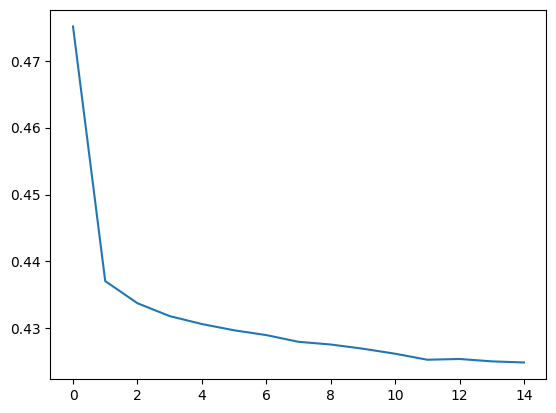

In [68]:
plt.plot(epoch, rmse.loss)

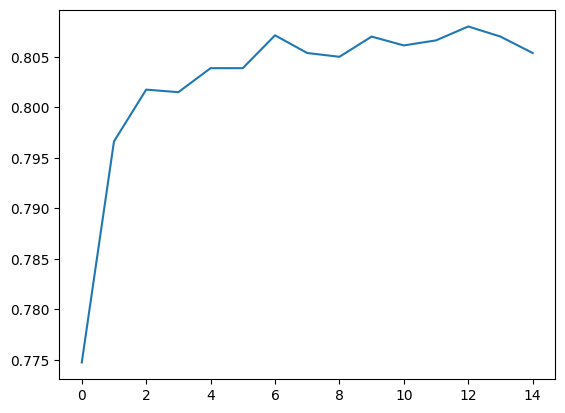

In [69]:
plt.plot(epoch, rmse.accuracy)

In [70]:
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

200/200 [==============================] - 1s 2ms/step - loss: 0.4365 - accuracy: 0.7970


[0.4364520311355591, 0.796999990940094]